In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [2]:
df=pd.read_csv("../../data/merged/len3_ship_mon_Y_agg_drop_never.csv",encoding="shift-jis",index_col=0)
df["ship_date"]

0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4187    2022-08-31
4188    2022-09-30
4189    2022-10-31
4190    2022-11-30
4191    2022-12-31
Name: ship_date, Length: 4192, dtype: object

Estimation

In [3]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4187    0
4188    0
4189    0
4190    0
4191    0
Name: mon_1, Length: 4192, dtype: uint8

In [4]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [5]:
# change to the datetime format
df['ship_date'] = pd.to_datetime(df["ship_date"], format='%Y-%m-%d')
df=df.set_index(["id","ship_date"])
# df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1420 entries, (114, Timestamp('2009-11-30 00:00:00')) to (799, Timestamp('2022-12-31 00:00:00'))
Columns: 117 entries, year to year_trend
dtypes: float64(14), int32(3), int64(78), object(10), uint8(12)
memory usage: 1.1+ MB


(117, 167, 18)

In [6]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

elapsed dummies


In [7]:
before_p=10
after_p=15
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)

+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15


## RX

                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
elapsed_m10         -0.4113     0.1332    -3.0874     0.0021     -0.6726     -0.1499
elapsed_m9          -0.2461     0.1178    -2.0882     0.0370     -0.4772     -0.0149
elapsed_m8          -0.1797     0.1074    -1.6741     0.0944     -0.3904      0.0309
elapsed_m7          -0.4110     0.1266    -3.2456     0.0012     -0.6594     -0.1625
elapsed_m6           0.0215     0.0814     0.2636     0.7921     -0.1382      0.1811
elapsed_m5          -0.1255     0.0479    -2.6210     0.0089     -0.2194     -0.0316
elapsed_m4          -0.0069     0.0659    -0.1042     0.9170     -0.1362      0.1224
elapsed_m3          -0.1215     0.0544    -2.2330     0.0257     -0.2282     -0.0147
elapsed_m2          -0.0624     0.0634    -0.9851     0.3248     

C:\Users\hakos\AppData\Local\Temp\ipykernel_19912\3481541034.py:18: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

mon_1, mon_2, mon_3, mon_4, mon_5, mon_6, mon_7, mon_8, mon_9, mon_10, mon_11, mon_12

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


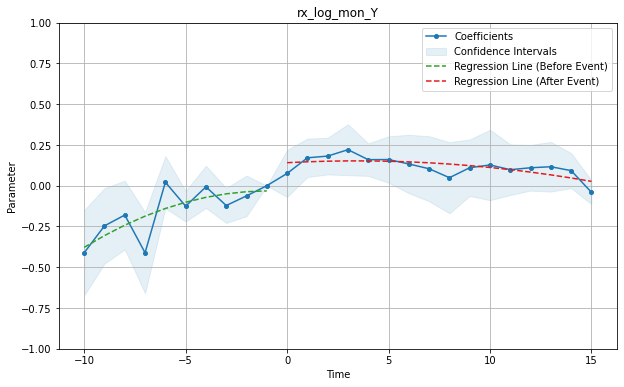

In [8]:
# take log
formula="log_rx_dom ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon_Y",title="rx_log_mon_Y",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
elapsed_m10           0.2596     0.5046     0.5144     0.6071     -0.7304      1.2495
elapsed_m9            0.0477     0.4866     0.0979     0.9220     -0.9070      1.0023
elapsed_m8           -0.5850     0.4770    -1.2266     0.2202     -1.5208      0.3507
elapsed_m7            0.3757     0.4687     0.8016     0.4229     -0.5438      1.2953
elapsed_m6           -0.9602     0.3676    -2.6121     0.0091     -1.6814     -0.2390
elapsed_m5           -0.8413     0.2738    -3.0731     0.0022     -1.3784     -0.3042
elapsed_m4           -0.2553     0.2499    -1.0214     0.3073     -0.7457      0.2351
elapsed_m3           -0.4120     0.3798    -1.0849     0.2782     -1.1571      0.3331
elapsed_m2           -0.4660     0.4354    -1.0703    

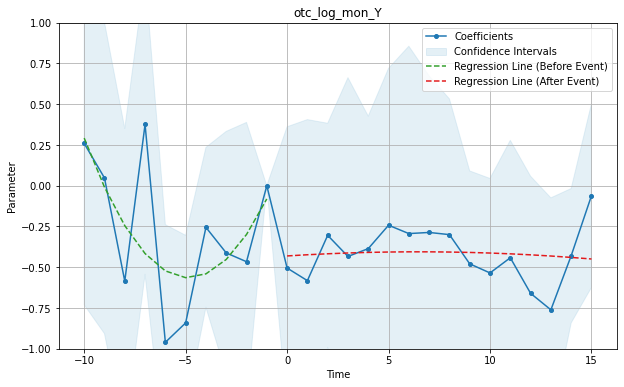

In [9]:
# take log

# till 20
# formula="log_otc_dom ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_dom ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_stock_otc_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon_Y",title="otc_log_mon_Y",ylim=(-1,1),plot_type="-o",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)